In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import os.path as op

In [3]:
import AFQ.utils.streamlines as aus
import AFQ.segmentation as afs
import AFQ.data as afd
import AFQ.tractography as aft
import AFQ.registration as reg
import AFQ.dti as dti
import AFQ.segmentation as seg

import nibabel as nib
import dipy.data as dpd
from dipy.data import fetcher

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/AFQ_data/templates 


In [4]:
dpd.fetch_stanford_hardi()
hardi_dir = op.join(fetcher.dipy_home, "stanford_hardi")
hardi_fdata = op.join(hardi_dir, "HARDI150.nii.gz")
hardi_fbval = op.join(hardi_dir, "HARDI150.bval")
hardi_fbvec = op.join(hardi_dir, "HARDI150.bvec")

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/stanford_hardi 


In [5]:
img = nib.load(hardi_fdata)

In [6]:
if not op.exists('./dti_FA.nii.gz'):
    dti_params = dti.fit_dti(hardi_fdata, hardi_fbval, hardi_fbvec, out_dir='.')
else:
    dti_params = {'AD': './dti_AD.nii.gz',
                  'FA': './dti_FA.nii.gz',
                  'MD': './dti_MD.nii.gz',
                  'RD': './dti_RD.nii.gz',
                  'params': './dti_params.nii.gz'}

In [7]:
if not op.exists('dti_streamlines.trk'):
    streamlines = list(aft.track(dti_params['params']))
    aus.write_trk('dti_streamlines.trk', streamlines, affine=img.affine)
else: 
    streamlines = aus.read_trk('dti_streamlines.trk')

In [8]:
templates = afd.read_templates()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/AFQ_data/templates 


In [9]:
#bundle_names = ["ATR", "CGC", "CST",
#                # "FA", "FP",
#                "HCC", "IFO", "ILF",
#                "SLF", "ARC", "UNC"]
bundle_names = ["ARC", "CST"]
# For the arcuate, we need to rename a few of these and duplicate the SLF ROI:
templates['ARC_roi1_L'] = templates['SLF_roi1_L']
templates['ARC_roi1_R'] = templates['SLF_roi1_R']
templates['ARC_roi2_L'] = templates['SLFt_roi2_L']
templates['ARC_roi2_R'] = templates['SLFt_roi2_R']

bundles = {}

for name in bundle_names:
    for hemi in ['_R', '_L']:
        bundles[name + hemi] = {'ROIs': [templates[name + '_roi1' + hemi], 
                                         templates[name + '_roi1' + hemi]],
                                'rules' : [True, True]}


In [10]:
MNI_T2_img = dpd.read_mni_template()

Data size is approximately 35MB
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/mni_template 


In [11]:
if not op.exists('mapping.nii.gz'):
    mapping = reg.syn_register_dwi(dwi, gtab)
else: 
    mapping = reg.read_mapping('mapping.nii.gz',img, MNI_T2_img)

In [12]:
fiber_groups = seg.segment(hardi_fdata,
                           hardi_fbval,
                           hardi_fbvec,
                           streamlines,
                           bundles,
                           mapping=mapping,
                           as_generator=False)

Data size is approximately 35MB
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/mni_template 


In [13]:
FA_img = nib.load('./dti_FA.nii.gz')
FA_data = FA_img.get_data()

In [14]:
bundles.keys()

dict_keys(['CST_L', 'ARC_L', 'ARC_R', 'CST_R'])

In [15]:
import imp
imp.reload(seg)

<module 'AFQ.segmentation' from '/Users/arokem/source/pyAFQ/AFQ/segmentation.py'>

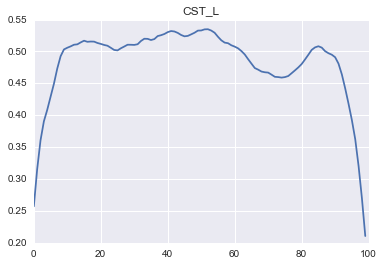

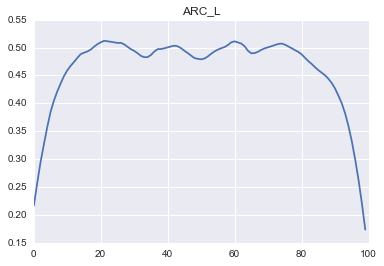

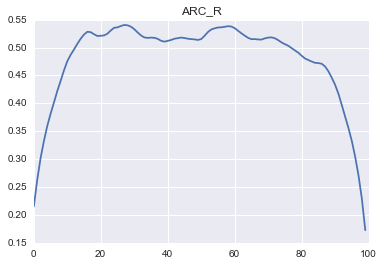

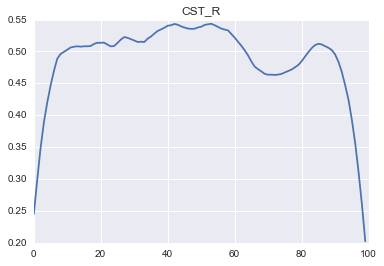

In [16]:
for bundle in bundles:
    fig, ax = plt.subplots(1)
    w = seg.gaussian_weights(fiber_groups[bundle])
    profile = seg.calculate_tract_profile(FA_data, fiber_groups[bundle], weights=w)
    ax.plot(profile)
    ax.set_title(bundle)